# Scoring

## Factor1_TDTS

In [99]:
! pip install yfinance

In [100]:
import yfinance as yf
import pandas as pd
from datetime import datetime
import pytz
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent))
from Func_app.config import SET50_TICKERS

# # 1. รายชื่อหุ้น SET50 
# SET50_TICKERS_BASE = [
#     "ADVANC", "AOT", "AWC", "BANPU", "BBL", "BDMS", "BEM", "BGRIM", "BH", "BJC",
#     "BPP", "CPALL", "CPF", "CPN", "CRC", "DELTA", "EGCO", "BSRC", "GULF", "HMPRO",
#     "IRPC", "KBANK", "KTB", "KTC", "LH", "MINT", "MTC", "OR", "OSP",
#     "PTT", "PTTEP", "PTTGC", "RATCH", "SAWAD", "SCB", "SCC", "SCGP", "TISCO", "TLI",
#     "TOP", "TTB", "TU", "VGI", "WHA", "GLOBAL", "BAM", "CPAXT", "GPSC", "BLA"
# ]

# SET50_TICKERS = [f"{ticker}.BK" for ticker in SET50_TICKERS_BASE]
# not use delta stock
set50_tickers = [ticker for ticker in SET50_TICKERS if ticker != "DELTA.BK"]
# set50_tickers = SET50_TICKERS.

def analyze_tdts_history(tickers, start_year=2022, end_year=2026):
    all_data = []
    print(f"กำลังดึงข้อมูลย้อนหลังปี {start_year}-{end_year} ...")

    for symbol in tickers:
        try:
            # ดึงข้อมูลหุ้น
            stock = yf.Ticker(symbol)

            # 1. ดึงประวัติราคา (ย้อนหลังเผื่อไว้หน่อย)
            # ดึงตั้งแต่ต้นปี start_year ถึงปัจจุบัน
            history = stock.history(start=f"{start_year}-01-01", end=f"{end_year+1}-12-31")

            # 2. ดึงประวัติปันผล
            dividends = stock.dividends

            # แปลง timezone ให้ตรงกัน (เพื่อเทียบวันที่)
            if not history.empty:
                history.index = history.index.normalize() # ตัดเวลาออกเหลือแค่วันที่

            if not dividends.empty:
                 dividends.index = dividends.index.normalize()

            # กรองเอาเฉพาะปันผลในช่วงปีที่ต้องการ
            mask = (dividends.index.year >= start_year) & (dividends.index.year <= end_year)
            target_dividends = dividends.loc[mask]

            if target_dividends.empty:
                continue

            # 3. วนลูปคำนวณ TDTS สำหรับการจ่ายปันผล "แต่ละครั้ง"
            for date, amount in target_dividends.items():
                # วันที่จ่ายปันผลใน yfinance คือ Ex-Date
                ex_date = date

                # ตรวจสอบว่ามีข้อมูลราคาในวัน Ex-Date หรือไม่
                if ex_date not in history.index:
                    continue

                # หา Index ของวัน Ex-Date
                loc_ex = history.index.get_loc(ex_date)

                # ถ้าเป็นวันแรกของข้อมูล จะไม่มี Cum Date (วันก่อนหน้า)
                if loc_ex == 0:
                    continue

                # วัน Cum Date คือวันทำการก่อนหน้า Ex-Date 1 วัน
                loc_cum = loc_ex - 1

                # ดึงข้อมูลราคาปิด (Close Price)
                p_ex = history.iloc[loc_ex]['Close']
                p_cum = history.iloc[loc_cum]['Close']
                date_cum = history.index[loc_cum]

                # --- คำนวณสูตร TDTS ---
                # Dividend Yield (DY)
                dy = (amount / p_cum) * 100

                # Price Drop (PD)
                pd_pct = ((p_cum - p_ex) / p_cum) * 100

                # TDTS
                if dy != 0:
                    t_dts = pd_pct / dy
                else:
                    t_dts = 0

                # เก็บข้อมูลลง List
                all_data.append({
                    'Stock': symbol.replace('', ''),
                    'Year': ex_date.year,
                    'Ex-Date': ex_date.strftime('%Y-%m-%d'),
                    'DPS (Baht)': amount,
                    'P_cum': p_cum,
                    'P_ex': p_ex,
                    'DY (%)': dy,
                    'PD (%)': pd_pct,
                    'TDTS': t_dts
                })

        except Exception as e:
            print(f"Error checking {symbol}: {e}")

    # สร้าง DataFrame
    df = pd.DataFrame(all_data)

    # เรียงลำดับตาม ชื่อหุ้น -> ปี -> วันที่
    if not df.empty:
        df = df.sort_values(by=['Stock', 'Ex-Date'], ascending=[True, False])

    return df

# --- รันฟังก์ชัน ---
df_results_T_DTS = analyze_tdts_history(set50_tickers)
df_results_T_DTS

กำลังดึงข้อมูลย้อนหลังปี 2022-2026 ...


$BSRC.BK: possibly delisted; no price data found  (1d 2022-01-01 -> 2027-12-31) (Yahoo error = "No data found, symbol may be delisted")
$BSRC.BK: possibly delisted; no price data found  (1d 1927-03-20 -> 2026-02-23) (Yahoo error = "No data found, symbol may be delisted")


Error checking BSRC.BK: 'RangeIndex' object has no attribute 'year'


,Stock,Year,Ex-Date,DPS (Baht),P_cum,P_ex,DY (%),PD (%),TDTS
7,ADVANC.BK,2025,2025-08-19,6.8900,287.110016,290.000000,2.399777,-1.006577,-0.419446
6,ADVANC.BK,2025,2025-02-20,5.7400,282.481079,276.367798,2.031995,2.164138,1.065032
5,ADVANC.BK,2024,2024-08-19,4.8700,226.109360,230.772690,2.153825,-2.062422,-0.957563
4,ADVANC.BK,2024,2024-02-19,4.6100,195.514221,196.086533,2.357885,-0.292721,-0.124146
3,ADVANC.BK,2023,2023-08-18,4.0000,201.021667,203.775375,1.989835,-1.369856,-0.688427
...,...,...,...,...,...,...,...,...,...
271,WHA.BK,2024,2024-05-09,0.1170,4.580949,4.643167,2.554056,-1.358194,-0.531779
270,WHA.BK,2023,2023-11-22,0.0669,4.474906,4.481165,1.495003,-0.139868,-0.093557
269,WHA.BK,2023,2023-05-11,0.1003,3.973449,3.973717,2.524256,-0.006750,-0.002674
268,WHA.BK,2022,2022-11-25,0.0669,3.232234,3.238273,2.069776,-0.186849,-0.090275


In [101]:
df_results_T_DTS[df_results_T_DTS['Stock'] == 'SCB.BK'][df_results_T_DTS['Year'] == 2023]

C:\Users\natta\AppData\Local\Temp\ipykernel_22432\3432150815.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_results_T_DTS[df_results_T_DTS['Stock'] == 'SCB.BK'][df_results_T_DTS['Year'] == 2023]


,Stock,Year,Ex-Date,DPS (Baht),P_cum,P_ex,DY (%),PD (%),TDTS
206,SCB.BK,2023,2023-09-13,2.50,95.108757,95.527733,2.628570,-0.440523,-0.167590
205,SCB.BK,2023,2023-04-17,5.19,82.244469,83.220154,6.310455,-1.186323,-0.187993


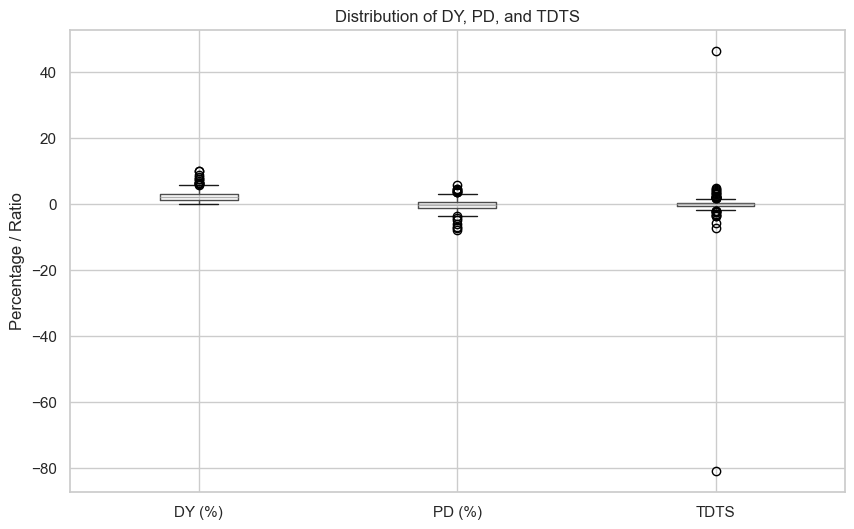

In [102]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

# 2. สั่ง plot โดยไม่ต้องใส่ figsize ข้างใน
df_results_T_DTS[['DY (%)', 'PD (%)', 'TDTS']].boxplot()

plt.title("Distribution of DY, PD, and TDTS")
plt.ylabel("Percentage / Ratio")
plt.show()

In [103]:
# หาตัวการที่ทำให้กราฟเบี้ยว
outlier = df_results_T_DTS[(df_results_T_DTS['TDTS'] < -10) | (df_results_T_DTS['TDTS'] > 10)]
outlier

,Stock,Year,Ex-Date,DPS (Baht),P_cum,P_ex,DY (%),PD (%),TDTS
45,BGRIM.BK,2023,2023-03-14,0.035000,36.166210,34.543152,0.096775,4.487775,46.373095
201,SAWAD.BK,2024,2024-05-08,0.010455,33.019634,33.865894,0.031663,-2.562900,-80.943096


In [104]:
df_results_T_DTS_clean = df_results_T_DTS.drop(outlier.index)
df_results_T_DTS_clean

,Stock,Year,Ex-Date,DPS (Baht),P_cum,P_ex,DY (%),PD (%),TDTS
7,ADVANC.BK,2025,2025-08-19,6.8900,287.110016,290.000000,2.399777,-1.006577,-0.419446
6,ADVANC.BK,2025,2025-02-20,5.7400,282.481079,276.367798,2.031995,2.164138,1.065032
5,ADVANC.BK,2024,2024-08-19,4.8700,226.109360,230.772690,2.153825,-2.062422,-0.957563
4,ADVANC.BK,2024,2024-02-19,4.6100,195.514221,196.086533,2.357885,-0.292721,-0.124146
3,ADVANC.BK,2023,2023-08-18,4.0000,201.021667,203.775375,1.989835,-1.369856,-0.688427
...,...,...,...,...,...,...,...,...,...
271,WHA.BK,2024,2024-05-09,0.1170,4.580949,4.643167,2.554056,-1.358194,-0.531779
270,WHA.BK,2023,2023-11-22,0.0669,4.474906,4.481165,1.495003,-0.139868,-0.093557
269,WHA.BK,2023,2023-05-11,0.1003,3.973449,3.973717,2.524256,-0.006750,-0.002674
268,WHA.BK,2022,2022-11-25,0.0669,3.232234,3.238273,2.069776,-0.186849,-0.090275


# Factor2_bf_af_avg


In [105]:
import yfinance as yf
import pandas as pd
from datetime import datetime

def calculate_tema(series, span):
    """ฟังก์ชันช่วยคำนวณ TEMA (Triple Exponential Moving Average)"""
    ema1 = series.ewm(span=span, adjust=False).mean()
    ema2 = ema1.ewm(span=span, adjust=False).mean()
    ema3 = ema2.ewm(span=span, adjust=False).mean()
    return (3 * ema1) - (3 * ema2) + ema3

def analyze_xd_tema_history(tickers, start_year=2022, end_year=2026, window=15):
    all_data = []
    print(f"กำลังดึงข้อมูลและคำนวณ TEMA({window}) ย้อนหลังปี {start_year}-{end_year} ...")

    for symbol in tickers:
        try:
            stock = yf.Ticker(symbol)

            # 1. ดึงข้อมูลย้อนหลัง (เผื่อ Buffer ให้ TEMA ทำงานเสถียรหน่อย จึงลบ start_year ไปอีก 1 ปี)
            # เช่น อยากได้ 2022 ให้ดึงตั้งแต่ 2021
            fetch_start = f"{start_year - 1}-01-01" 
            history = stock.history(start=fetch_start, end=f"{end_year+1}-12-31")
            dividends = stock.dividends

            if history.empty:
                continue

            # 2. คำนวณ TEMA เตรียมไว้ใน DataFrame เลย
            history['TEMA'] = calculate_tema(history['Close'], span=window)

            # 3. จัดการ Timezone ให้ตรงกัน
            history.index = history.index.normalize()
            if not dividends.empty:
                dividends.index = dividends.index.normalize()

            # กรองเอาเฉพาะปันผลในช่วงปีที่ต้องการวิเคราะห์
            mask = (dividends.index.year >= start_year) & (dividends.index.year <= end_year)
            target_dividends = dividends.loc[mask]

            if target_dividends.empty:
                continue

            # 4. วนลูปวิเคราะห์เหตุการณ์ XD แต่ละครั้ง
            for date, amount in target_dividends.items():
                ex_date = date

                # ตรวจสอบว่ามีข้อมูลในวัน Ex-Date หรือไม่
                if ex_date not in history.index:
                    continue

                # หาตำแหน่ง Index ของวัน XD
                loc_xd = history.index.get_loc(ex_date)

                # --- Boundary Check ---
                # ตรวจสอบว่าข้อมูลมีเพียงพอสำหรับ Window หน้าและหลังหรือไม่
                # ต้องมีข้อมูลย้อนหลัง window วัน และมีข้อมูลล่วงหน้า window วัน
                if (loc_xd - window < 0) or (loc_xd + window >= len(history)):
                    continue

                # --- ดึงค่า TEMA ที่ตำแหน่งต่างๆ ---
                # loc_xd - window : จุดเริ่มต้นช่วงก่อน XD
                # loc_xd - 1      : วันทำการก่อน XD (Pre-XD)
                # loc_xd          : วัน XD
                # loc_xd + window : จุดสิ้นสุดช่วงหลัง XD
                
                tema_prev_win = history.iloc[loc_xd - window]['TEMA']
                tema_pre_xd   = history.iloc[loc_xd - 1]['TEMA']
                tema_xd       = history.iloc[loc_xd]['TEMA']
                tema_post_win = history.iloc[loc_xd + window]['TEMA']
                
                actual_price_xd = history.iloc[loc_xd]['Close']

                # --- คำนวณ Return โดยใช้ค่า TEMA ---
                # Ret_Bf: TEMA เปลี่ยนแปลงเท่าไหร่ในช่วง Window ก่อนถึงวัน XD
                ret_bf = ((tema_pre_xd - tema_prev_win) / tema_prev_win) * 100

                # Ret_Af: TEMA เปลี่ยนแปลงเท่าไหร่หลังจากวัน XD ไปจนจบ Window
                ret_af = ((tema_post_win - tema_xd) / tema_xd) * 100

                # เก็บข้อมูล
                all_data.append({
                    'Stock': symbol.replace('.BK', ''), # ตัด .BK ออกให้ดูสะอาดตา
                    'Year': ex_date.year,
                    'Ex-Date': ex_date.strftime('%Y-%m-%d'),
                    'DPS': amount,
                    'Price_Close': round(actual_price_xd, 2),
                    'Price_TEMA': round(tema_xd, 2),
                    'Ret_Bf_TEMA (%)': round(ret_bf, 2),
                    'Ret_Af_TEMA (%)': round(ret_af, 2)
                })

        except Exception as e:
            print(f"Error checking {symbol}: {e}")

    # สร้าง DataFrame และเรียงข้อมูล
    df = pd.DataFrame(all_data)
    
    if not df.empty:
        df = df.sort_values(by=['Stock', 'Ex-Date'], ascending=[True, False])

    return df

# --- รันฟังก์ชัน ---
# window=15 หมายถึง ดูย้อนหลัง 15 วัน และ ไปข้างหน้า 15 วัน (และใช้คำนวณ TEMA 15 ด้วย)
df_results_tema = analyze_xd_tema_history(set50_tickers, start_year=2022, end_year=2026, window=15)


# ตัวอย่างการดูเฉพาะหุ้น CPALL
df_results_tema[df_results_tema['Stock'] == 'BJC']

กำลังดึงข้อมูลและคำนวณ TEMA(15) ย้อนหลังปี 2022-2026 ...


$BSRC.BK: possibly delisted; no price data found  (1d 2021-01-01 -> 2027-12-31) (Yahoo error = "No data found, symbol may be delisted")
$BSRC.BK: possibly delisted; no price data found  (1d 1927-03-20 -> 2026-02-23) (Yahoo error = "No data found, symbol may be delisted")


,Stock,Year,Ex-Date,DPS,Price_Close,Price_TEMA,Ret_Bf_TEMA (%),Ret_Af_TEMA (%)
66,BJC,2025,2025-08-27,0.15,17.00,16.82,-10.91,26.41
65,BJC,2025,2025-04-29,0.56,23.00,23.16,4.29,-8.47
64,BJC,2024,2024-08-27,0.15,21.96,21.43,7.97,8.43
63,BJC,2024,2024-04-30,0.65,23.84,23.70,2.54,-9.35
62,BJC,2023,2023-08-24,0.15,33.23,33.09,1.65,-7.67
61,BJC,2023,2023-05-03,0.65,36.58,36.09,3.32,-3.73
60,BJC,2022,2022-08-24,0.15,30.94,31.16,4.35,1.45
59,BJC,2022,2022-04-28,0.51,31.25,30.85,-4.62,8.13


In [106]:
df_group = df_results_tema.groupby('Stock').aggregate({'DPS': 'mean', 'Ret_Af_TEMA (%)': 'mean', 'Ret_Bf_TEMA (%)': 'mean'})
df_group.head(10)

,DPS,Ret_Af_TEMA (%),Ret_Bf_TEMA (%)
Stock,,,
ADVANC,4.755000,-0.51125,2.93250
AOT,0.653333,2.05000,4.74000
AWC,0.041940,-6.11250,-1.84750
BAM,0.457500,-7.10750,-0.62500
BANPU,0.290000,1.65500,2.09375
BBL,3.062500,1.79375,0.91375
BDMS,0.325000,1.36375,1.56750
BEM,0.122500,-3.55250,-0.43000
BGRIM,0.163125,2.96625,-4.29125


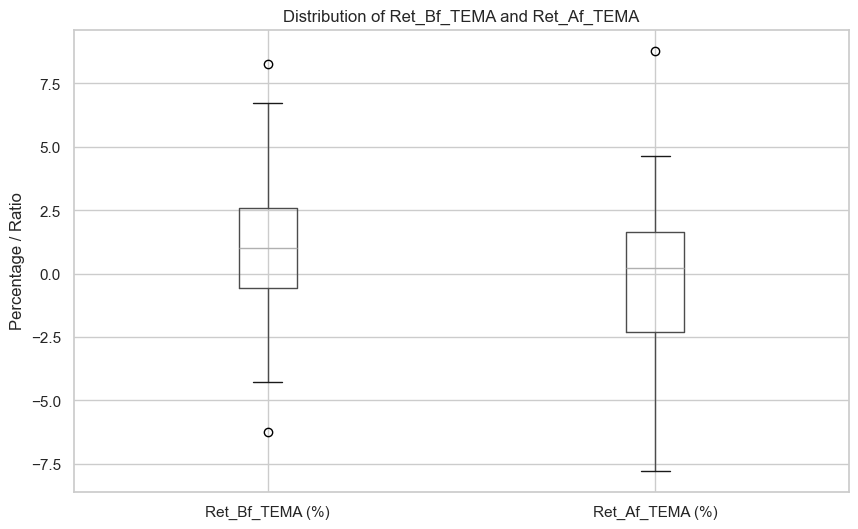

In [107]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

# 2. สั่ง plot โดยไม่ต้องใส่ figsize ข้างใน
df_group[['Ret_Bf_TEMA (%)', 'Ret_Af_TEMA (%)']].boxplot()

plt.title("Distribution of Ret_Bf_TEMA and Ret_Af_TEMA")
plt.ylabel("Percentage / Ratio")
plt.show()

## Merge (TEMA + TDTS)

In [108]:
import pandas as pd

# สมมติว่าคุณมี DataFrame 2 ตัวชื่อ df_tdts และ df_tema
df_tdts = df_results_T_DTS_clean
df_tema = df_results_tema

# --- ขั้นตอนที่ 1: จัด Format ชื่อหุ้นให้ตรงกัน ---
# ลบ .BK ออกจาก df_tdts เพื่อให้เหมือนกับ df_tema
df_tdts['Stock'] = df_tdts['Stock'].str.replace('.BK', '')

# --- ขั้นตอนที่ 2: แปลงวันที่ให้เป็น datetime object (เพื่อความชัวร์) ---
df_tdts['Ex-Date'] = pd.to_datetime(df_tdts['Ex-Date'])
df_tema['Ex-Date'] = pd.to_datetime(df_tema['Ex-Date'])

# --- ขั้นตอนที่ 3: เลือกเฉพาะคอลัมน์จาก TEMA ที่ต้องการมารวม ---
# เราไม่เอา Year หรือ DPS ซ้ำ เพราะใน TDTS มีอยู่แล้ว
cols_to_use = ['Stock', 'Ex-Date', 'Price_TEMA', 'Ret_Bf_TEMA (%)', 'Ret_Af_TEMA (%)']
df_tema_subset = df_tema[cols_to_use]

# --- ขั้นตอนที่ 4: สั่ง Merge ---
# ใช้ key คือ 'Stock' และ 'Ex-Date' ตรงกัน
df_merged = pd.merge(
    df_tdts, 
    df_tema_subset, 
    on=['Stock', 'Ex-Date'], 
    how='inner'  # inner = เอาเฉพาะแถวที่ข้อมูลชนกันเจอทั้งคู่ (แนะนำ), left = ยึด TDTS เป็นหลัก
)

# แสดงผล
df_merged

,Stock,Year,Ex-Date,DPS (Baht),P_cum,P_ex,DY (%),PD (%),TDTS,Price_TEMA,Ret_Bf_TEMA (%),Ret_Af_TEMA (%)
0,ADVANC,2025,2025-08-19,6.8900,287.110016,290.000000,2.399777,-1.006577,-0.419446,291.24,0.66,0.54
1,ADVANC,2025,2025-02-20,5.7400,282.481079,276.367798,2.031995,2.164138,1.065032,281.94,3.16,-7.71
2,ADVANC,2024,2024-08-19,4.8700,226.109360,230.772690,2.153825,-2.062422,-0.957563,231.77,9.00,9.26
3,ADVANC,2024,2024-02-19,4.6100,195.514221,196.086533,2.357885,-0.292721,-0.124146,194.93,-2.03,1.12
4,ADVANC,2023,2023-08-18,4.0000,201.021667,203.775375,1.989835,-1.369856,-0.688427,201.25,-0.51,-2.28
...,...,...,...,...,...,...,...,...,...,...,...,...
292,WHA,2024,2024-05-09,0.1170,4.580949,4.643167,2.554056,-1.358194,-0.531779,4.65,5.82,8.65
293,WHA,2023,2023-11-22,0.0669,4.474906,4.481165,1.495003,-0.139868,-0.093557,4.45,-1.84,3.67
294,WHA,2023,2023-05-11,0.1003,3.973449,3.973717,2.524256,-0.006750,-0.002674,3.99,1.74,0.27
295,WHA,2022,2022-11-25,0.0669,3.232234,3.238273,2.069776,-0.186849,-0.090275,3.26,-3.20,4.90


In [109]:
df_merged[df_merged['Stock'] == 'BJC']

,Stock,Year,Ex-Date,DPS (Baht),P_cum,P_ex,DY (%),PD (%),TDTS,Price_TEMA,Ret_Bf_TEMA (%),Ret_Af_TEMA (%)
62,BJC,2025,2025-08-27,0.15,16.950001,17.000000,0.884956,-0.294981,-0.333328,16.82,-10.91,26.41
63,BJC,2025,2025-04-29,0.56,22.738771,22.996490,2.462754,-1.133390,-0.460213,23.16,4.29,-8.47
64,BJC,2024,2024-08-27,0.15,21.916304,21.964685,0.684422,-0.220757,-0.322545,21.43,7.97,8.43
65,BJC,2024,2024-04-30,0.65,23.213980,23.838787,2.800037,-2.691513,-0.961242,23.70,2.54,-9.35
66,BJC,2023,2023-08-24,0.15,32.855270,33.229691,0.456548,-1.139605,-2.496134,33.09,1.65,-7.67
67,BJC,2023,2023-05-03,0.65,35.977692,36.583534,1.806675,-1.683940,-0.932066,36.09,3.32,-3.73
68,BJC,2022,2022-08-24,0.15,30.569578,30.936230,0.490684,-1.199400,-2.444344,31.16,4.35,1.45
69,BJC,2022,2022-04-28,0.51,30.560455,31.253969,1.668823,-2.269318,-1.359831,30.85,-4.62,8.13


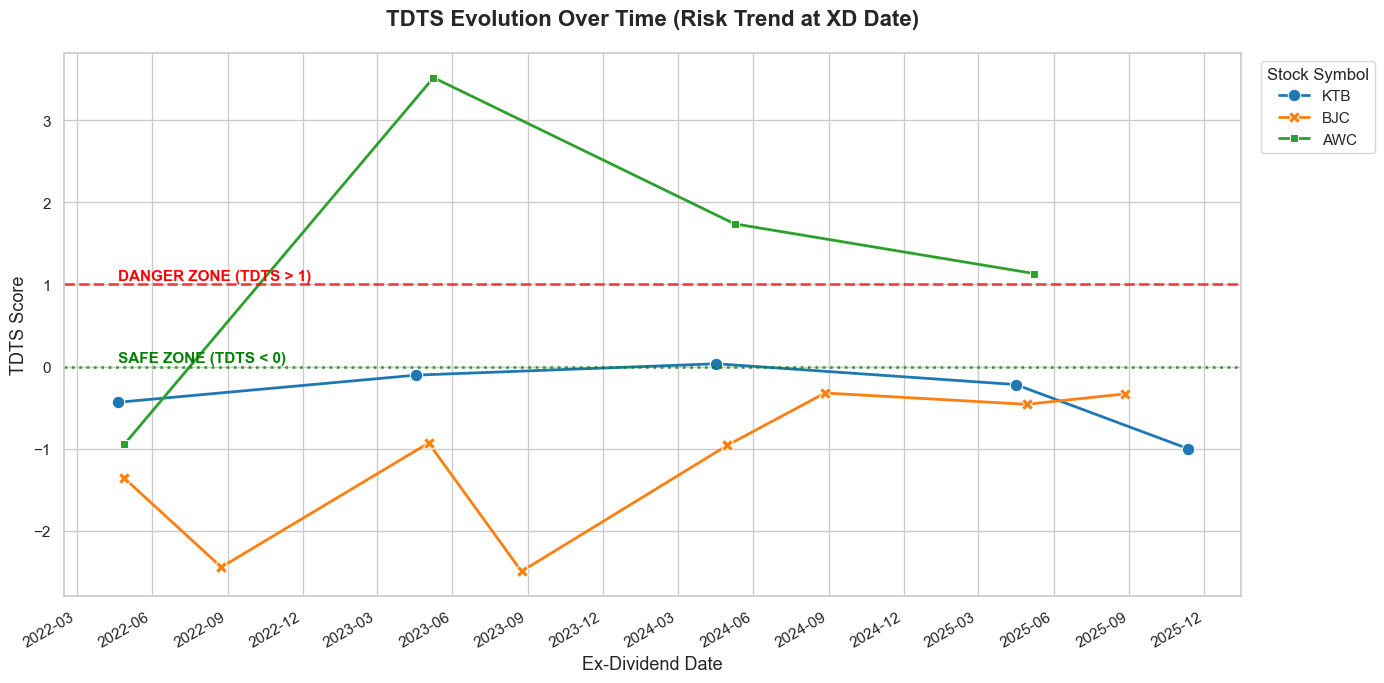

In [110]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd

# --- 1. เตรียมข้อมูลจาก df_merged ---
# สมมติว่าคุณมี df_merged อยู่แล้วจากการรัน process_cluster_and_score
# แต่ถ้า column ชื่อ 'T_DTS' (มี underscore) หรือ 'TDTS' (ขีดกลาง) ให้ปรับตรงนี้
target_col = 'T_DTS' if 'T_DTS' in df_merged.columns else 'TDTS'

# แปลง Ex_Date เป็น datetime ให้ชัวร์
df_plot = df_merged.copy()
df_plot['Ex-Date'] = pd.to_datetime(df_plot['Ex-Date'])

# --- 2. เลือกหุ้นที่ต้องการดู (Filter) ---
# แนะนำให้เลือกดูทีละกลุ่ม เช่น Top 3 และ Bottom 3 จากการ Ranking
# คุณสามารถเปลี่ยนรายชื่อตรงนี้ได้ตามใจชอบ
selected_stocks = ['BJC', 'KTB', 'AWC']  
df_filtered = df_plot[df_plot['Stock'].isin(selected_stocks)].sort_values('Ex-Date')

# --- 3. สร้างกราฟ ---
plt.figure(figsize=(14, 7))
sns.set_theme(style="whitegrid")

# สร้าง Line Chart + Markers (จุด XD)
# hue='Stock' จะแยกสีเส้นตามรายชื่อหุ้นให้อัตโนมัติ
sns.lineplot(
    data=df_filtered,
    x='Ex-Date', 
    y=target_col, 
    hue='Stock', 
    style='Stock',         # ใช้เส้นประ/เส้นทึบ ต่างกันเพื่อให้อ่านง่าย
    markers=True,          # แสดงจุด (Point) ตรงวัน XD
    dashes=False,          # (Optional) ถ้าอยากได้เส้นทึบหมดให้แก้เป็น True
    linewidth=2,
    palette="tab10",       # ชุดสีที่ตัดกันชัดเจน
    markersize=9
)

# --- 4. เพิ่มเส้น Reference Zone ---
# เส้น TDTS = 1 (Dividend Trap Zone)
plt.axhline(y=1, color='red', linestyle='--', linewidth=2, alpha=0.7)
plt.text(df_filtered['Ex-Date'].min(), 1.05, 'DANGER ZONE (TDTS > 1)', 
         color='red', fontsize=11, fontweight='bold')

# เส้น TDTS = 0 (Safe Zone)
plt.axhline(y=0, color='green', linestyle=':', linewidth=2, alpha=0.7)
plt.text(df_filtered['Ex-Date'].min(), 0.05, 'SAFE ZONE (TDTS < 0)', 
         color='green', fontsize=11, fontweight='bold')

# --- 5. ตกแต่งกราฟ ---
plt.title('TDTS Evolution Over Time (Risk Trend at XD Date)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Ex-Dividend Date', fontsize=13)
plt.ylabel('TDTS Score', fontsize=13)
plt.legend(title='Stock Symbol', bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=11)

# จัด Format แกนวันที่
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3)) # โชว์ทุก 3 เดือน
plt.gcf().autofmt_xdate() # เอียงวันที่ให้อ่านง่าย

plt.tight_layout()
plt.show()

In [111]:
df_agg = df_merged.groupby('Stock').aggregate({'DY (%)': 'mean', 'TDTS': 'mean', 'Ret_Af_TEMA (%)': 'mean', 'Ret_Bf_TEMA (%)': 'mean'})
df_agg.loc[['CPAXT']]

,DY (%),TDTS,Ret_Af_TEMA (%),Ret_Bf_TEMA (%)
Stock,,,,
CPAXT,1.565721,0.034947,-3.02,-3.01


d:\Users\natta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\Users\natta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\Users\natta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\Users\natta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

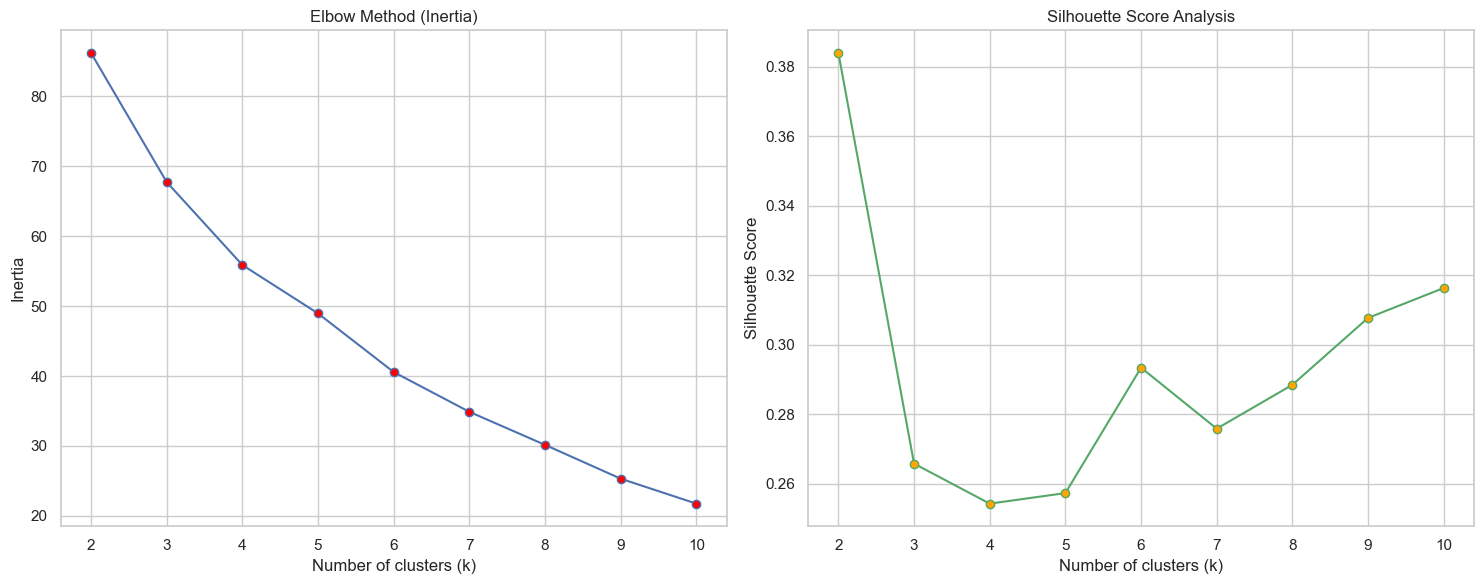

    k    Inertia  Silhouette Score
0   2  86.226720          0.383916
1   3  67.751255          0.265809
2   4  55.889941          0.254304
3   5  48.961761          0.257339
4   6  40.572658          0.293407
5   7  34.879626          0.275863
6   8  30.154480          0.288477
7   9  25.315897          0.307717
8  10  21.746022          0.316320


In [112]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# 1. เตรียมข้อมูล (Clean & Scale)
# ลบแถวที่มี NaN (ถ้ามี) เพื่อไม่ให้ error
df_clustering = df_agg.dropna().copy()

# กำหนด Features ที่จะใช้
features = ['TDTS', 'Ret_Af_TEMA (%)', 'Ret_Bf_TEMA (%)']
X = df_clustering[features]

# Standardize ข้อมูล (ปรับสเกลให้ mean=0, std=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. คำนวณ Inertia และ Silhouette Score สำหรับ k ต่างๆ
inertia_values = []
silhouette_scores = []
k_range = range(2, 11)  # ลองแบ่งกลุ่มตั้งแต่ 2 ถึง 10 กลุ่ม

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    
    # เก็บค่า Inertia (Sum of squared distances of samples to their closest cluster center)
    inertia_values.append(kmeans.inertia_)
    
    # เก็บค่า Silhouette Score
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(score)

# 3. พล็อตกราฟแสดงผล
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# กราฟ Elbow Method (Inertia)
ax1.plot(k_range, inertia_values, 'bo-', markerfacecolor='red')
ax1.set_title('Elbow Method (Inertia)')
ax1.set_xlabel('Number of clusters (k)')
ax1.set_ylabel('Inertia')
ax1.grid(True)

# กราฟ Silhouette Score
ax2.plot(k_range, silhouette_scores, 'go-', markerfacecolor='orange')
ax2.set_title('Silhouette Score Analysis')
ax2.set_xlabel('Number of clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.grid(True)

plt.tight_layout()
plt.show()

# แสดงค่า Score แบบตารางเพื่อให้ดูง่าย
df_scores = pd.DataFrame({
    'k': k_range,
    'Inertia': inertia_values,
    'Silhouette Score': silhouette_scores
})
print(df_scores)

d:\Users\natta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


=== K-Means Clustering (k=4) Results ===
Inertia: 55.89
Silhouette Score: 0.2543

=== Cluster Summary ===
   Cluster      TDTS  Ret_Af_TEMA (%)  Ret_Bf_TEMA (%)  Count
0        0  0.562644        -5.926786        -2.112857      7
1        1  0.012460        -0.837155         1.856515     18
2        2 -0.674311         0.118657         4.186250      9
3        3 -0.217639         2.842433        -0.435567     12


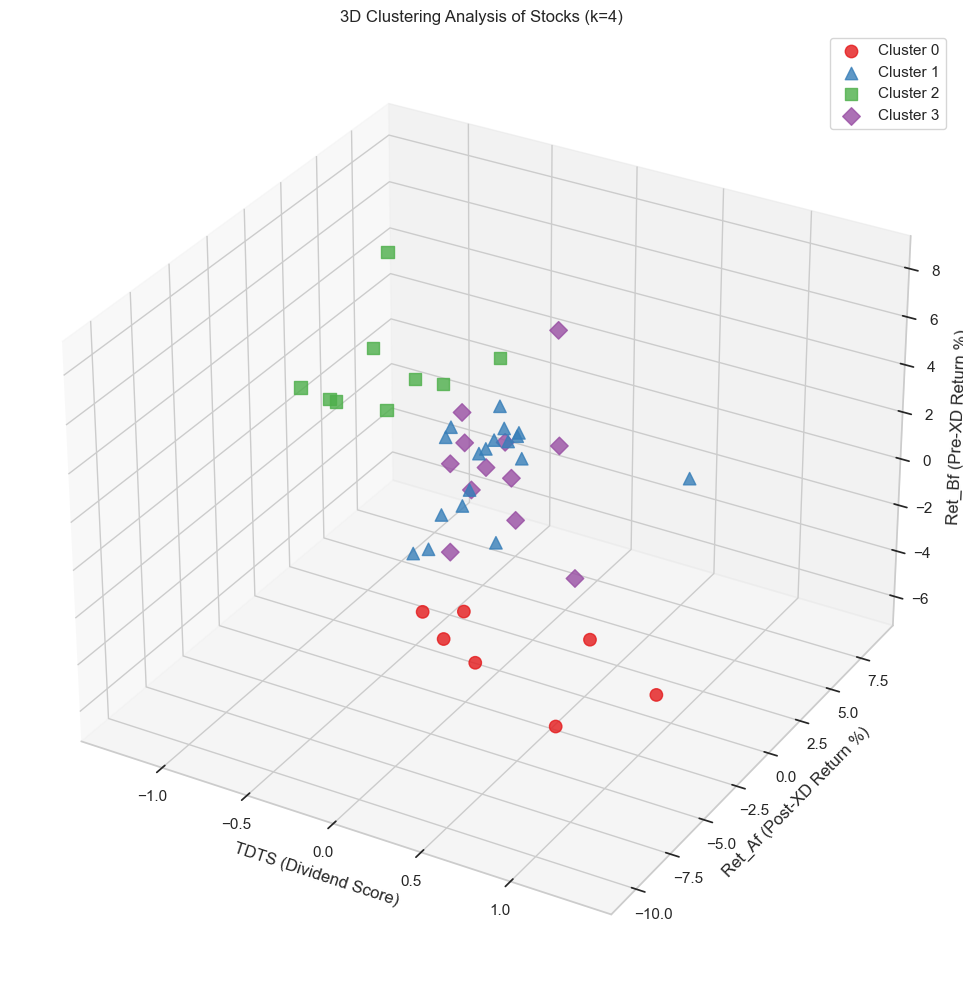

--------------------------------------------------

Cluster 0 (7 stocks):
AWC, BAM, CPAXT, CRC, IRPC, SAWAD, VGI

Cluster 1 (18 stocks):
ADVANC, BANPU, BEM, BPP, EGCO, GPSC, KBANK, KTC, LH, MTC, OR, PTT, PTTEP, RATCH, SCGP

Cluster 2 (9 stocks):
AOT, BDMS, BH, BJC, CPALL, CPF, HMPRO, MINT, TLI

Cluster 3 (12 stocks):
BBL, BGRIM, BLA, CPN, GLOBAL, KTB, OSP, PTTGC, SCB, SCC, TTB, WHA


In [113]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # จำเป็นสำหรับ 3D Plot
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# 1. เตรียมข้อมูล (Clean & Scale)
# ใช้ df_agg ที่คุณ aggregate มาแล้ว
df_model = df_agg.dropna().copy()
features = ['TDTS', 'Ret_Af_TEMA (%)', 'Ret_Bf_TEMA (%)']

# Standardize ข้อมูล (ปรับสเกลให้เป็นมาตรฐานเดียวกัน)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_model[features])

# 2. สร้างโมเดล K-Means (k=4)
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df_model['Cluster'] = kmeans.fit_predict(X_scaled)

# คำนวณ Score เพื่อดูคุณภาพ
inertia = kmeans.inertia_
sil_score = silhouette_score(X_scaled, df_model['Cluster'])

print(f"=== K-Means Clustering (k={k}) Results ===")
print(f"Inertia: {inertia:.2f}")
print(f"Silhouette Score: {sil_score:.4f}")

# ดูค่าเฉลี่ยของแต่ละกลุ่ม (Centroids)
cluster_summary = df_model.groupby('Cluster')[features].mean().reset_index()
cluster_summary['Count'] = df_model.groupby('Cluster')['TDTS'].count().values
print("\n=== Cluster Summary ===")
print(cluster_summary)

# 3. สร้างกราฟ 3D Scatter Plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# กำหนดสีสำหรับ 4 กลุ่ม
colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3']  # Red, Blue, Green, Purple
markers = ['o', '^', 's', 'D']

for cluster_id in range(k):
    subset = df_model[df_model['Cluster'] == cluster_id]
    ax.scatter(
        subset['TDTS'], 
        subset['Ret_Af_TEMA (%)'], 
        subset['Ret_Bf_TEMA (%)'], 
        c=colors[cluster_id],
        marker=markers[cluster_id],
        s=80,      # ขนาดจุด
        alpha=0.8, # ความโปร่งใส
        label=f'Cluster {cluster_id}'
    )

# ตั้งชื่อแกน
ax.set_xlabel('TDTS (Dividend Score)')
ax.set_ylabel('Ret_Af (Post-XD Return %)')
ax.set_zlabel('Ret_Bf (Pre-XD Return %)')
ax.set_title(f'3D Clustering Analysis of Stocks (k={k})')

# มุมมอง (สามารถปรับหมุนได้ถ้าทำใน Notebook Interactive)
# ax.view_init(elev=20, azim=45) 

plt.legend()
plt.tight_layout()
plt.show()

# 4. (แถม) แสดงรายชื่อหุ้นในแต่ละกลุ่ม
print("-" * 50)
for i in range(k):
    stocks = df_model[df_model['Cluster'] == i].index.tolist()
    print(f"\nCluster {i} ({len(stocks)} stocks):")
    print(", ".join(stocks[:15])) # โชว์แค่ 15 ตัวแรก

In [114]:
df_model
df_scoring = df_model.copy()
df_scoring['Total_Score (%)'] = (df_scoring['DY (%)'] * (1 - df_scoring['TDTS']))\
      + df_scoring['Ret_Af_TEMA (%)']
#df scoring without cluster column
df_scoring_without_cluster = df_scoring.drop(columns=['Cluster'])
df_scoring_without_cluster.sort_values(by='Total_Score (%)', ascending=False)

,DY (%),TDTS,Ret_Af_TEMA (%),Ret_Bf_TEMA (%),Total_Score (%)
Stock,,,,,
KTB,4.693770,-0.345355,8.794000,2.376000,15.108787
SCB,4.308930,-0.388678,1.250000,0.204286,7.233715
TISCO,5.669109,-0.128652,0.618571,1.691429,7.017023
BLA,1.547611,-0.298178,4.637500,-1.928750,6.646574
OSP,2.387649,0.023377,4.143333,0.384444,6.475167
TLI,4.844460,-0.610141,-1.462500,5.935000,6.337764
WHA,2.376431,-0.449694,2.870000,1.473750,6.315098
TTB,3.527706,-0.222078,1.793750,0.117500,6.104882
BANPU,3.968329,-0.104534,1.655000,2.093750,6.038155


In [115]:
# Map cluster IDs to stable profile names using coordinate matching
import numpy as np
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
from sklearn.preprocessing import StandardScaler

# Define ideal profiles (order: TDTS, Ret_Af_TEMA (%), Ret_Bf_TEMA (%))
ideal_profiles = {
    'Golden Goose (Strong Trend)':    np.array([-0.5,  1.0,  1.0]),
    'Rebound Star (Buy on Dip)':  np.array([-1.0,  1.0, -1.0]),
    'Dividend Trap (Avoid)':        np.array([ 2.5, -3.0, -3.0]),
    'Sell on Fact (Neutral)':       np.array([ 0.0, -1.0,  1.0])
}
profile_names = list(ideal_profiles.keys())
ideal_vectors = np.array(list(ideal_profiles.values()))

# Features used for clustering — ensure the same order used when training KMeans
features = ['TDTS', 'Ret_Af_TEMA (%)', 'Ret_Bf_TEMA (%)']
# Recompute scaler/X_scaled from df_model to ensure we operate on same space
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_model[features])

cluster_ids = sorted(df_model['Cluster'].unique())
cluster_centroids = []
for c_id in cluster_ids:
    mask = df_model['Cluster'] == c_id
    centroid = X_scaled[mask].mean(axis=0)
    cluster_centroids.append(centroid)
cluster_centroids = np.array(cluster_centroids)

if len(cluster_centroids) > 0:
    distances = cdist(cluster_centroids, ideal_vectors, metric='euclidean')
    row_idx, col_idx = linear_sum_assignment(distances)
    cluster_mapping = {}
    for r, c in zip(row_idx, col_idx):
        real_cluster_id = cluster_ids[r]
        assigned_name = profile_names[c]
        cluster_mapping[real_cluster_id] = assigned_name
    df_scoring['Cluster_Name'] = df_scoring['Cluster'].map(cluster_mapping)
else:
    df_scoring['Cluster_Name'] = 'Unclassified'

# Show scoring table with stable cluster names
df_scoring

,DY (%),TDTS,Ret_Af_TEMA (%),Ret_Bf_TEMA (%),Cluster,Total_Score (%),Cluster_Name
Stock,,,,,,,
ADVANC,2.159813,-0.239816,-0.511250,2.932500,1,2.166521,Sell on Fact (Neutral)
AOT,1.151286,-0.160725,2.050000,4.740000,2,3.386327,Golden Goose (Strong Trend)
AWC,1.392771,1.360796,-6.112500,-1.847500,0,-6.615006,Dividend Trap (Avoid)
BAM,4.459621,0.133061,-7.107500,-0.625000,0,-3.241280,Dividend Trap (Avoid)
BANPU,3.968329,-0.104534,1.655000,2.093750,1,6.038155,Sell on Fact (Neutral)
BBL,2.327757,-0.347532,1.793750,0.913750,3,4.930477,Rebound Star (Buy on Dip)
BDMS,1.323918,-1.291568,1.363750,1.567500,2,4.397599,Golden Goose (Strong Trend)
BEM,1.674202,-0.124765,-3.552500,-0.430000,1,-1.669417,Sell on Fact (Neutral)
BGRIM,0.948379,0.271588,2.182857,-3.814286,3,2.873668,Rebound Star (Buy on Dip)


In [116]:
cluster_summary

,Cluster,TDTS,Ret_Af_TEMA (%),Ret_Bf_TEMA (%),Count
0,0,0.562644,-5.926786,-2.112857,7
1,1,0.012460,-0.837155,1.856515,18
2,2,-0.674311,0.118657,4.186250,9
3,3,-0.217639,2.842433,-0.435567,12
